### Example with DataLinks and LinkLikelihood class
Testing a way to measure scores from co-occurences in the data.

In [1]:
# data locations
DATASET = "C:\\Users\\FlorianHuber\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_MS2LDA = DATASET + "\\lda\\code\\"
PATH_MGF_DATA = DATASET + "\\Data\\Crusemann_dataset\\Crusemann_only_Clutered_Data\\"
MIBIG_JSON_DIR = DATASET + "\\Data\\mibig\\mibig_json_1.4"

NODES_FILE = PATH_MGF_DATA + "clusterinfosummarygroup_attributes_withIDs\\0d51c5b6c73b489185a5503d319977ab..out"

MGF_FILE = PATH_MGF_DATA + "METABOLOMICS-SNETS-c36f90ba-download_clustered_spectra-main.mgf"
EDGES_FILE = PATH_MGF_DATA + 'networkedges_selfloop\\9a93d720f69143bb9f971db39b5d2ba2.pairsinfo'

ROOT_PATH = DATASET + "\\Data\mibig_select\\"
FOLDERS = ['NRPS','Others','PKSI','PKS-NRP_Hybrids','PKSother','RiPPs','Saccharides','Terpene']
ANTISMASH_DIR = DATASET +"\\Data\\Crusemann_dataset\\bgc_crusemann\\"

from nplinker_constants import nplinker_setup
nplinker_setup(LDA_PATH=PATH_MS2LDA)

In [2]:
# import from NPlinker
from metabolomics import load_spectra
from metabolomics import load_metadata
from metabolomics import load_edges
from metabolomics import make_families
from genomics import loadBGC_from_cluster_files
from genomics import make_mibig_bgc_dict

from data_linking import DataLinks
from data_linking import LinkLikelihood
from data_linking import LinkFinder

# import general packages
import os
import glob

In [3]:
# load, initialize data
nplinker_setup(LDA_PATH=PATH_MS2LDA)

spectra = load_spectra(MGF_FILE)
load_edges(spectra, EDGES_FILE)
#families = make_families(spectra)
metadata = load_metadata(spectra, NODES_FILE)

input_files = []
ann_files = []
mibig_bgc_dict = make_mibig_bgc_dict(MIBIG_JSON_DIR)

for folder in FOLDERS:
    fam_file = os.path.join(ROOT_PATH, folder)
    cluster_file = glob.glob(fam_file + os.sep + folder + "_clustering*")
    annotation_files = glob.glob(fam_file + os.sep + "Network_*")
    input_files.append(cluster_file[0])
    ann_files.append(annotation_files[0])
gcf_list, bgc_list, strain_list = loadBGC_from_cluster_files(input_files, ann_files, antismash_dir=ANTISMASH_DIR, antismash_format = 'flat', mibig_bgc_dict=mibig_bgc_dict)

Loaded 5930 molecules
Found 1816 MiBIG json files


Now the data from the gene cluster families and spectra is loaded and initilized. 

The classes **DataLinks** and **LinkProbability** were written to test a possible alternative way to get correlation scores. The scoring is based on creating numpy co-occurence matrices which in principle should allow for very fast calculations.

In [4]:
# extract relevant linking mappings calculate co-occurences
data_links = DataLinks()
data_links.load_data(spectra, gcf_list, strain_list)
data_links.find_correlations(include_singletons=False)

Create mappings between spectra, gcfs, and strains.
Create co-occurence matrices: spectra<->strains + and gcfs<->strains.
Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf
  Done  1574  of  1574  type2s
  Done  5930  of  5930  type1s. Done  4500  of  5930  type1s.

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf
  Done  1574  of  1574  type2s
  Done  458  of  458  type1s.



In [5]:
# Calculate link probabilities, such as:
# P(gcf_x | spec_y) = probability to find gcf_x in a strain, given spec_y is present
# P(gcf_x | not spec_y) = probability to find gcf_x in a strain, given spec_y is NOT present 
likelihoods = LinkLikelihood()
likelihoods.calculate_likelihoods(data_links, type='spec-gcf')
likelihoods.calculate_likelihoods(data_links, type='fam-gcf')

Calculating likelihood matrices of type:  spec-gcf
Calculating likelihood matrices of type:  fam-gcf


### Select potential link candidates
#### Search for links between GCFs and spectra, and between GCFs and mol. families
Can now be done using the metcalf score or based on the likelihood ("likelihood score"). 

In [6]:
linkcandidates = LinkFinder()

linkcandidates.metcalf_scoring(data_links,
                        both=10, 
                        type1_not_gcf=-10, 
                        gcf_not_type1=0,
                        type='spec-gcf')

linkcandidates.metcalf_scoring(data_links,
                        both=10, 
                        type1_not_gcf=-10, 
                        gcf_not_type1=0,
                        type='fam-gcf')

Here is the second type of score(the one I had used before). Like the metcalf score it takes into account the directionality BGC-->compound-->spectrum, which suggests that the most relevant likelihoods are: 

P(gcf|type1) - If type1 is the result of only one particular gene cluster,
                            this value should be high (close or equal to 1)

P(type1|not gcf) - Following the same logic, this value should be very 
                                small or 0 ("no gene cluster, no compound") P(gcf_x | spec_y).
                                
This is then weighted by the number of strains this co-occurence was found in.

In [7]:
linkcandidates.likelihood_scoring(data_links, likelihoods, 
                        alpha_weighing=0.5,
                        type='spec-gcf')

linkcandidates.likelihood_scoring(data_links, likelihoods, 
                        alpha_weighing=0.5,
                        type='fam-gcf')

Using those scores it is then possible to select suitable, promising candidates for potential links between spectra and GCFs, or mol.families and GCFs.

In [8]:
link_candidates_spec = linkcandidates.select_link_candidates(data_links, likelihoods,
                               P_cutoff=0.9, 
                               main_score='likescore',
                               score_cutoff=0.6, 
                               type='spec-gcf')

link_candidates_fam = linkcandidates.select_link_candidates(data_links, likelihoods,
                               P_cutoff=0.8, 
                               main_score='likescore',
                               score_cutoff=0, 
                               type='fam-gcf')

14433  candidates selected with  P(gcf|spec)  >=  0.9  and a link score >=  0.6 .
3802  candidates selected with  P(gcf|fam)  >=  0.8  and a link score >=  0 .


What becomes apparent is that the score I used and metcalf are indeed very similar in the sense that they nearly sort candidates the same way. The score I use here ("likescore"or "likelihood score") might have the advantage that it is normalized to (0,1). 

In [10]:
# Show table of potential gcf<-> spectrum link candidates
#link_candidates_fam.head()
link_candidates_fam.nlargest(10, 'likelihood score')

,family_id,GCF id,P(gcf|fam),P(fam|gcf),P(gcf|not fam),P(fam|not gcf),co-occur in # strains,metcalf score,likelihood score,BGC class
259,119.0,970.0,1.0,0.100000,0.323741,0.0,5.0,50.0,0.917915,Others
1207,196.0,426.0,1.0,0.102041,0.316547,0.0,5.0,50.0,0.917915,Others
29,35.0,574.0,1.0,0.108108,0.235714,0.0,4.0,40.0,0.864665,Others
30,35.0,583.0,1.0,0.173913,0.135714,0.0,4.0,40.0,0.864665,Others
31,35.0,1511.0,1.0,0.117647,0.214286,0.0,4.0,40.0,0.864665,Saccharides
269,125.0,251.0,1.0,0.093023,0.278571,0.0,4.0,40.0,0.864665,Others
270,125.0,384.0,1.0,0.083333,0.314286,0.0,4.0,40.0,0.864665,Others
271,125.0,418.0,1.0,0.137931,0.178571,0.0,4.0,40.0,0.864665,Others
272,125.0,422.0,1.0,0.074074,0.357143,0.0,4.0,40.0,0.864665,Others
273,125.0,499.0,1.0,0.080000,0.328571,0.0,4.0,40.0,0.864665,Others


#### Export to cytoscape
There is now an added function to create network files that can be imported to Cytoscape.

In [11]:
# This will create a network from spectra <-> GCF links (including molecular family member links)
# Output is a graphml file
linkcandidates.create_cytoscape_files(data_links, 
                               'test_network.graphml', 
                               link_type='spec-gcf',
                               score_type='likescore')

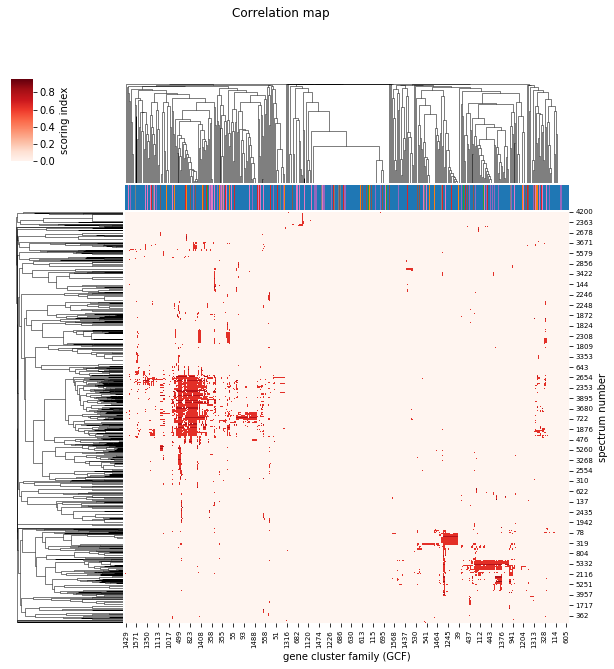

In [12]:
# do some test plotting to inspect the kind of results we get from there...
M_links = linkcandidates.plot_candidates(P_cutoff=0.95, 
                        score_type='likescore', 
                        score_cutoff=0.6, 
                        type='spec-gcf')

#### Show link candidates between GCFs and molecular families
Again done based on "likelihood score", but using metcalf scores gives nearly identical results here.

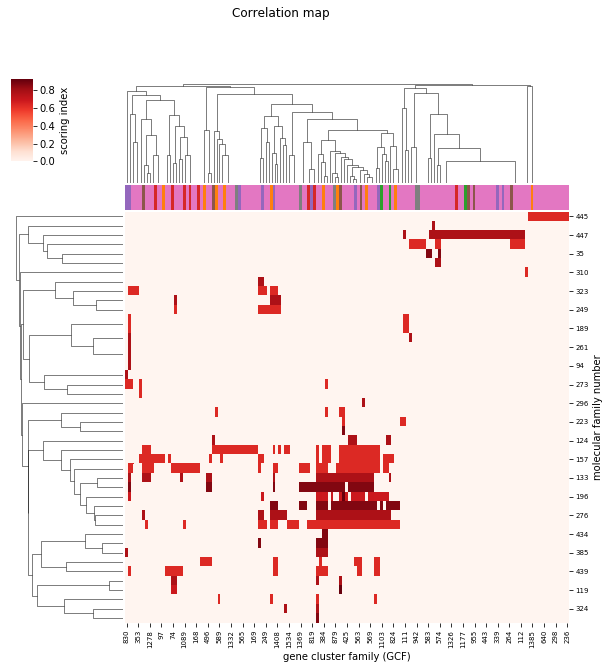

In [14]:
# do some test plotting to inspect the kind of results we get from there...
M_links = linkcandidates.plot_candidates(P_cutoff=0.9, 
                        score_type='likescore', 
                        score_cutoff=0.5, 
                        type='fam-gcf')